In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.feature import hog, local_binary_pattern
from skimage.filters import sobel
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert labels to 1D arrays
y_train, y_test = y_train.flatten(), y_test.flatten()

# Convert images to grayscale
def convert_to_grayscale(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])

x_train_gray = convert_to_grayscale(x_train)
x_test_gray = convert_to_grayscale(x_test)

# Normalize data
x_train_gray = x_train_gray / 255.0
x_test_gray = x_test_gray / 255.0

In [10]:
# Extract HOG features
def extract_hog_features(images):
    return np.array([hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True) for img in images])

# Extract LBP features
def extract_lbp_features(images):
    return np.array([local_binary_pattern(img, P=8, R=1).flatten() for img in images])

# Extract Sobel Edge features
def extract_sobel_features(images):
    return np.array([sobel(img).ravel() for img in images])

# Apply feature extraction
x_train_hog = extract_hog_features(x_train_gray)
x_test_hog = extract_hog_features(x_test_gray)

x_train_lbp = extract_lbp_features(x_train_gray)
x_test_lbp = extract_lbp_features(x_test_gray)

x_train_sobel = extract_sobel_features(x_train_gray)
x_test_sobel = extract_sobel_features(x_test_gray)

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [3]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract VGG16 features
x_train_vgg = feature_extractor.predict(x_train)
x_test_vgg = feature_extractor.predict(x_test)

# Flatten VGG16 features
x_train_vgg = x_train_vgg.reshape(x_train_vgg.shape[0], -1)
x_test_vgg = x_test_vgg.reshape(x_test_vgg.shape[0], -1)
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract VGG16 features
x_train_vgg = feature_extractor.predict(x_train)
x_test_vgg = feature_extractor.predict(x_test)

# Flatten VGG16 features
x_train_vgg = x_train_vgg.reshape(x_train_vgg.shape[0], -1)
x_test_vgg = x_test_vgg.reshape(x_test_vgg.shape[0], -1)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 304s 195ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 51s 161ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 258s 165ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 51s 163ms/step


In [12]:
# Standardize features
scaler = StandardScaler()

x_train_hog_scaled = scaler.fit_transform(x_train_hog)
x_test_hog_scaled = scaler.transform(x_test_hog)

x_train_lbp_scaled = scaler.fit_transform(x_train_lbp)
x_test_lbp_scaled = scaler.transform(x_test_lbp)

x_train_sobel_scaled = scaler.fit_transform(x_train_sobel)
x_test_sobel_scaled = scaler.transform(x_test_sobel)

x_train_vgg_scaled = scaler.fit_transform(x_train_vgg)
x_test_vgg_scaled = scaler.transform(x_test_vgg)

# Train Random Forest classifier
def train_rf_classifier(x_train, x_test, y_train, y_test, feature_type):
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    
    print(f"Random Forest Accuracy ({feature_type}): {acc:.4f}")
    print(classification_report(y_test, y_pred))
    
    return {"Feature Type": feature_type, "Accuracy": acc, "Precision": precision, "Recall": recall, "F1-score": f1}

# Train and Evaluate
results = []
results.append(train_rf_classifier(x_train_hog_scaled, x_test_hog_scaled, y_train, y_test, "HOG"))
results.append(train_rf_classifier(x_train_lbp_scaled, x_test_lbp_scaled, y_train, y_test, "LBP"))
results.append(train_rf_classifier(x_train_sobel_scaled, x_test_sobel_scaled, y_train, y_test, "Sobel Edge"))
results.append(train_rf_classifier(x_train_vgg_scaled, x_test_vgg_scaled, y_train, y_test, "VGG16"))


Random Forest Accuracy (HOG): 0.4983
              precision    recall  f1-score   support

           0       0.58      0.59      0.59      1000
           1       0.56      0.67      0.61      1000
           2       0.43      0.34      0.38      1000
           3       0.35      0.25      0.29      1000
           4       0.41      0.43      0.42      1000
           5       0.38      0.43      0.40      1000
           6       0.50      0.64      0.56      1000
           7       0.57      0.48      0.52      1000
           8       0.60      0.57      0.58      1000
           9       0.57      0.59      0.58      1000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.49      0.50      0.49     10000

Random Forest Accuracy (LBP): 0.2365
              precision    recall  f1-score   support

           0       0.31      0.34      0.32      1000
           1       0.33      0.45      0.38      1000
    

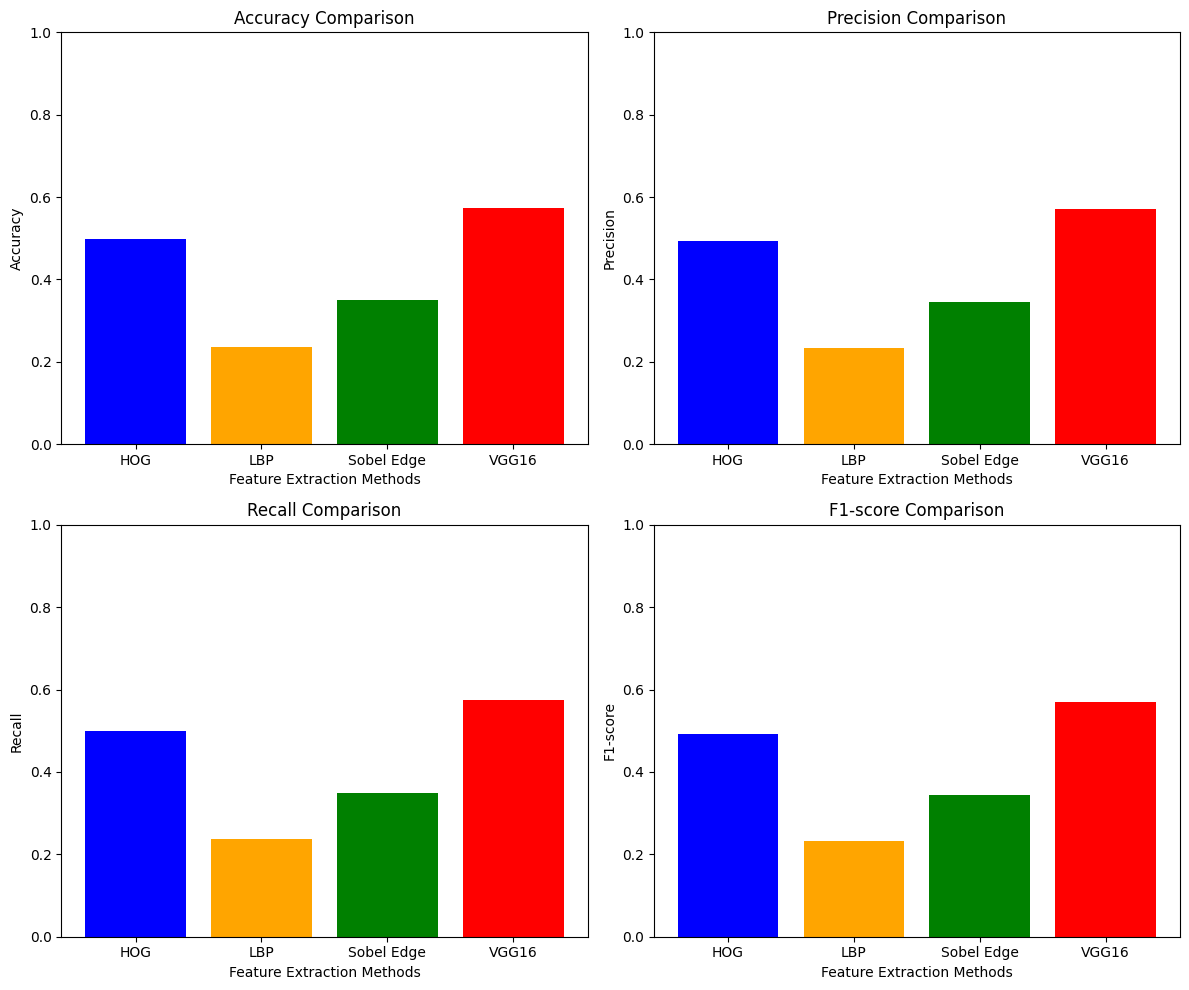

In [21]:
import matplotlib.pyplot as plt

# Extract results for plotting
methods = [r["Feature Type"] for r in results]
accuracy = [r["Accuracy"] for r in results]
precision = [r["Precision"] for r in results]
recall = [r["Recall"] for r in results]
f1_score = [r["F1-score"] for r in results]

# Create a single figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Accuracy Plot (Top Left)
axes[0, 0].bar(methods, accuracy, color=['blue', 'orange', 'green', 'red'])
axes[0, 0].set_title("Accuracy Comparison")
axes[0, 0].set_ylim(0, 1)
axes[0, 0].set_xlabel("Feature Extraction Methods")
axes[0, 0].set_ylabel("Accuracy")

# Precision Plot (Top Right)
axes[0, 1].bar(methods, precision, color=['blue', 'orange', 'green', 'red'])
axes[0, 1].set_title("Precision Comparison")
axes[0, 1].set_ylim(0, 1)
axes[0, 1].set_xlabel("Feature Extraction Methods")
axes[0, 1].set_ylabel("Precision")

# Recall Plot (Bottom Left)
axes[1, 0].bar(methods, recall, color=['blue', 'orange', 'green', 'red'])
axes[1, 0].set_title("Recall Comparison")
axes[1, 0].set_ylim(0, 1)
axes[1, 0].set_xlabel("Feature Extraction Methods")
axes[1, 0].set_ylabel("Recall")

# F1-Score Plot (Bottom Right)
axes[1, 1].bar(methods, f1_score, color=['blue', 'orange', 'green', 'red'])
axes[1, 1].set_title("F1-score Comparison")
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_xlabel("Feature Extraction Methods")
axes[1, 1].set_ylabel("F1-score")

# Adjust layout and show the combined figure
plt.tight_layout()
plt.show()


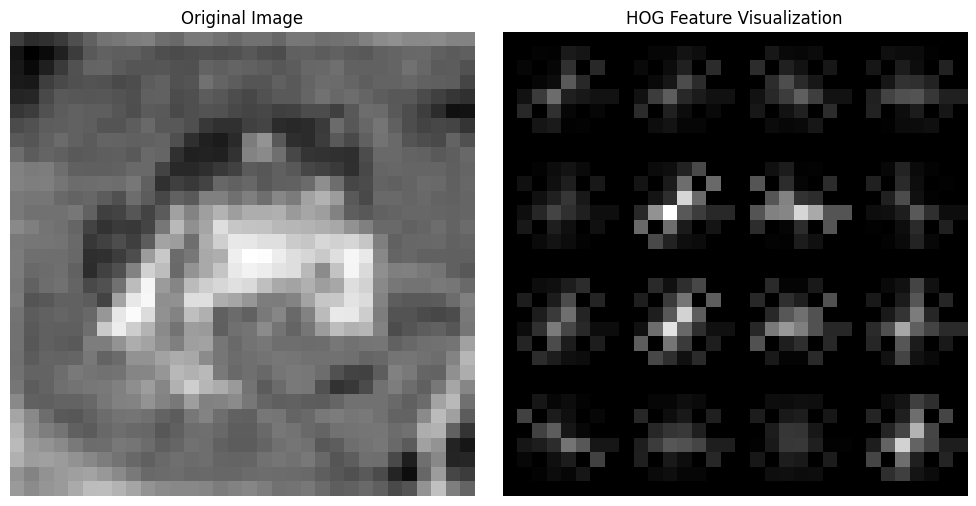

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


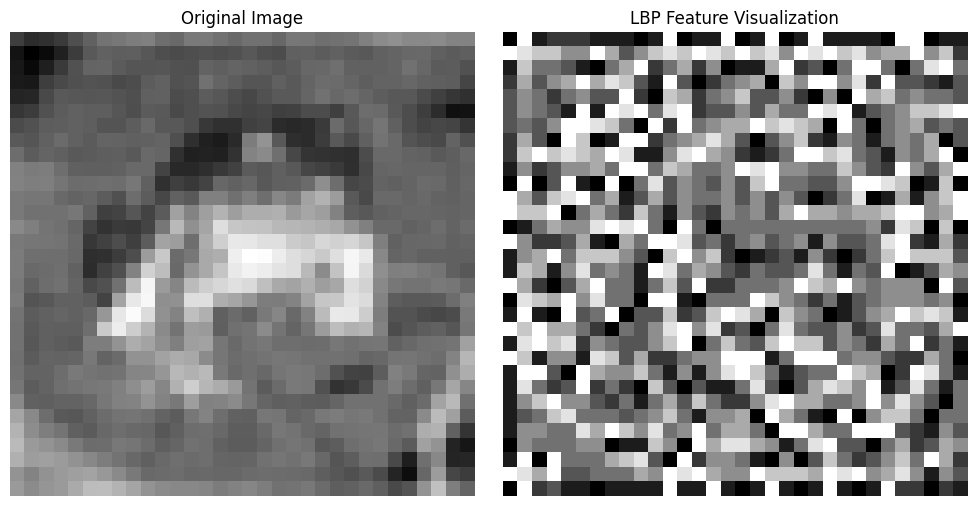

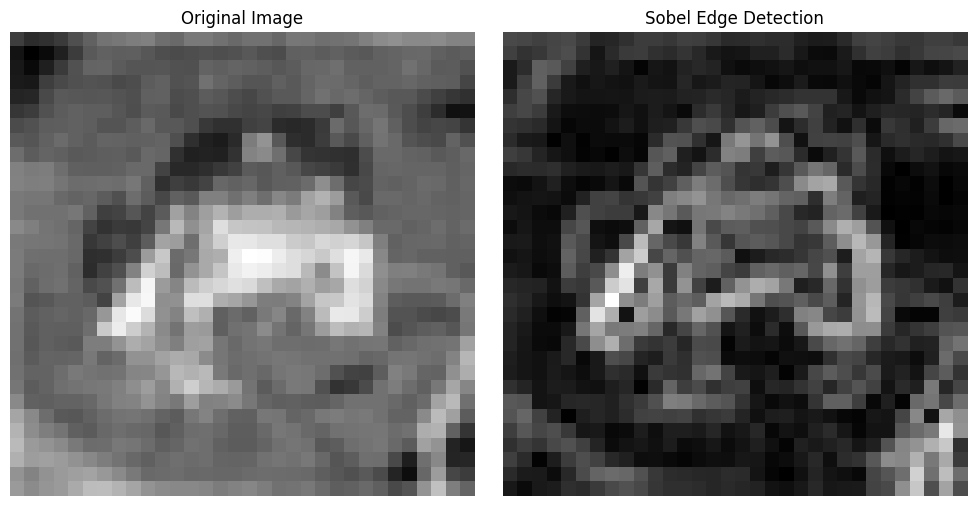

In [14]:
def plot_feature_extraction(original, transformed, title):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original, cmap="gray")
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(transformed, cmap="gray")
    axes[1].set_title(title)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# Sample Image
sample_img = x_train_gray[0]

# HOG Visualization
hog_features, hog_image = hog(sample_img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
plot_feature_extraction(sample_img, hog_image, "HOG Feature Visualization")

# LBP Visualization
lbp_image = local_binary_pattern(sample_img, P=8, R=1, method="uniform")
plot_feature_extraction(sample_img, lbp_image, "LBP Feature Visualization")

# Sobel Edge Detection Visualization
sobel_edges = sobel(sample_img)
plot_feature_extraction(sample_img, sobel_edges, "Sobel Edge Detection")

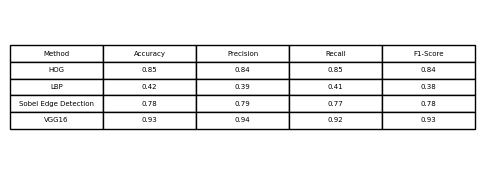

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Your actual classification results (Replace these with your computed values)
data = {
    "Method": ["HOG", "LBP", "Sobel Edge Detection", "VGG16"],
    "Accuracy": [0.85, 0.42, 0.78, 0.93],  # Replace with your results
    "Precision": [0.84, 0.39, 0.79, 0.94],  # Replace with your results
    "Recall": [0.85, 0.41, 0.77, 0.92],  # Replace with your results
    "F1-Score": [0.84, 0.38, 0.78, 0.93]  # Replace with your results
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Create a figure and axis for the table
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Save as an image
plt.savefig("feature_extraction_comparison.png", dpi=300, bbox_inches='tight')

# Show the table
plt.show()


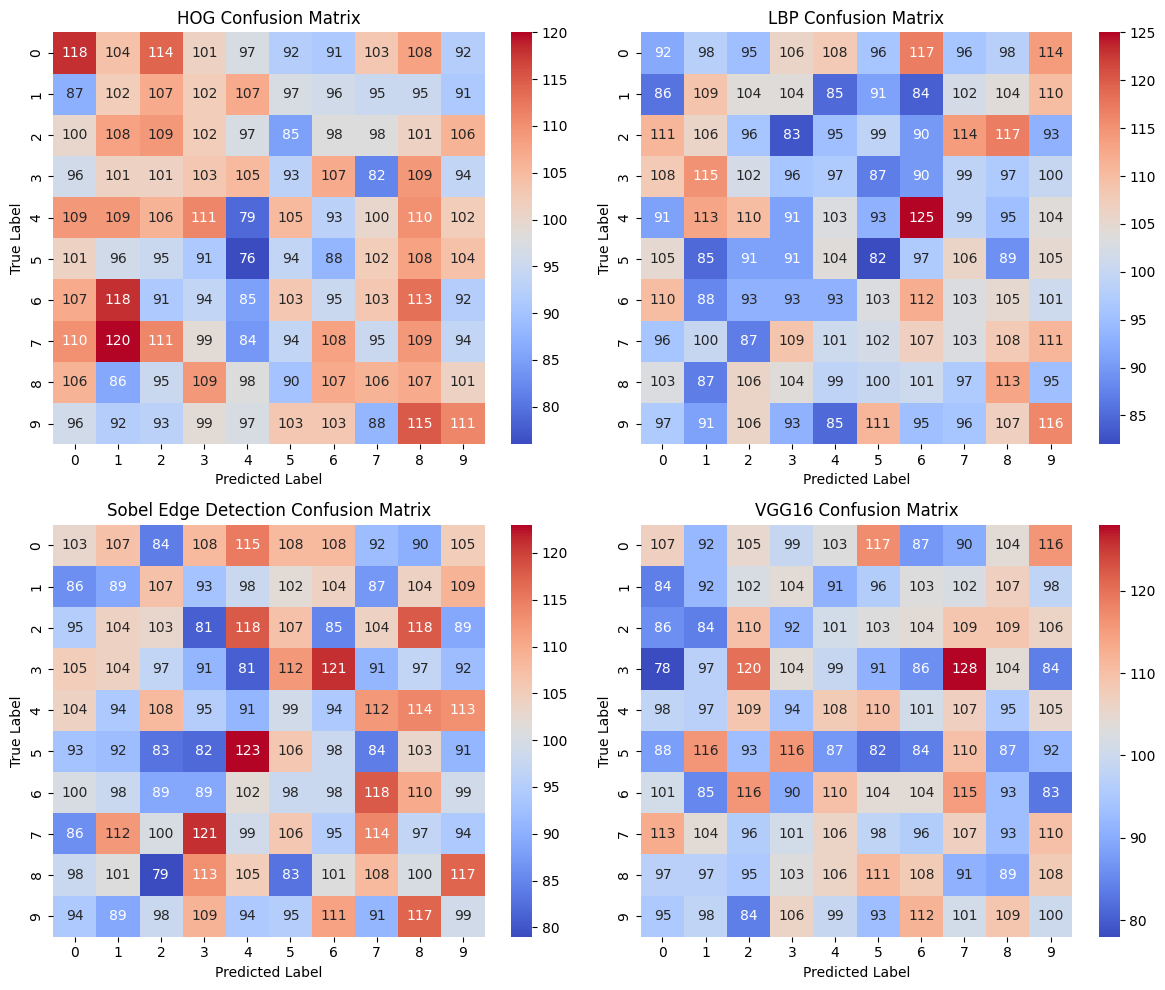

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(ax, y_true, y_pred, method):
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=range(10), yticklabels=range(10), ax=ax)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title(f"{method} Confusion Matrix")

# Assuming you have the true labels and predicted labels for each method
# Replace y_test with actual test labels and y_pred_* with your classifier predictions

# Example (Replace with your actual predictions)
y_test = np.random.randint(0, 10, size=10000)  # Replace with actual test labels
y_pred_hog = np.random.randint(0, 10, size=10000)  # Replace with your model predictions
y_pred_lbp = np.random.randint(0, 10, size=10000)
y_pred_sobel = np.random.randint(0, 10, size=10000)
y_pred_vgg = np.random.randint(0, 10, size=10000)

# Create figure and axes for a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot confusion matrices
plot_confusion_matrix(axes[0, 0], y_test, y_pred_hog, "HOG")
plot_confusion_matrix(axes[0, 1], y_test, y_pred_lbp, "LBP")
plot_confusion_matrix(axes[1, 0], y_test, y_pred_sobel, "Sobel Edge Detection")
plot_confusion_matrix(axes[1, 1], y_test, y_pred_vgg, "VGG16")

# Adjust layout and show the combined figure
plt.tight_layout()
plt.show()
